
# Weave 101
This Colab notebook provides an introduction to Weave by Weights & Biases. No prior experience with Weights & Biases is needed.

In [ ]:
%%capture
!pip install wandb weave openai langgraph langchain_core langchain_openai python-dotenv

Before running the following cell, make sure to add the `WANDB_API_KEY` and `OPENAI_API_KEY` to the .env file in this repo

In [ ]:
from dotenv import load_dotenv
import os

# Load variables from .env first
load_dotenv()

# Source WANDB_API_KEY and set OpenAI-compatible client env for W&B Inference
wandb_key = os.getenv("WANDB_API_KEY")
if wandb_key:
    os.environ["WANDB_API_KEY"] = wandb_key
    os.environ["OPENAI_API_KEY"] = wandb_key  # reuse for OpenAI-compatible clients
    # Support both env names used by different clients/wrappers
    os.environ["OPENAI_BASE_URL"] = "https://api.inference.wandb.ai/v1"
    os.environ["OPENAI_API_BASE"] = "https://api.inference.wandb.ai/v1"

print("WANDB_API_KEY loaded:", bool(wandb_key))
print("OPENAI_BASE_URL:", os.getenv("OPENAI_BASE_URL"))


In [ ]:
# Optional to run this cell - but if you are using a single tenant deployment of wandb, you would need to change the url
os.environ['WANDB_BASE_URL'] = 'https://api.wandb.ai'

In [ ]:
ENTITY = 'smle-demo' # YOUR TEAM NAME GOES HERE!
PROJECT = "weave-101-notebook"  # W&B project's name for tracking my-team/weave-101-notebook

# Traces

Weave provides [powerful tracing capabilities](https://weave-docs.wandb.ai/guides/tracking/) to track and version objects and function calls in your applications. This comprehensive system enables better monitoring, debugging, and iterative development of AI-powered applications, allowing you to "track insights between commits."

To track function calls(inputs, outputs, code ...etc) simply a function you want to trace with `weave.op()`:


In [ ]:
import weave

weave.init(f'{ENTITY}/{PROJECT}') # <-- initialize tracking for a specific W&B project

@weave.op()   # <-- All you need to add is 1 line of code 💚
def add_four(x):
  return x + 4

result = add_four(42)
print(result)

After running the code block above, Weave will display a link under the colab cell to the trace of the function call. You can click on the link to view the trace

## Out-of-the-Box Integrations
Weave provides automatic logging [integrations](https://weave-docs.wandb.ai/guides/integrations/) for popular LLM providers(OpenAI, Mistral, Anthropic ... etc) and orchestration frameworks(e.g: LangChain, CrewAI, ADK .. etc). These integrations allow you to seamlessly trace calls made through various libraries, enhancing your ability to monitor and analyze your AI applications. Here, we're automatically tracking all calls to OpenAI.

In [ ]:
import weave, os, openai

weave.init(f'{ENTITY}/{PROJECT}')      

client = openai.OpenAI(
    base_url=os.getenv("OPENAI_BASE_URL", "https://api.inference.wandb.ai/v1"),
    api_key=os.getenv("WANDB_API_KEY"),
    project=f"{ENTITY}/{PROJECT}",
)
response = client.chat.completions.create(
  model="meta-llama/Llama-3.1-8B-Instruct",
  messages=[
      {
          "role": "system",
          "content": "You are a grammar checker, correct the following user input."
      },
      {
          "role": "user",
          "content": "That was so easy, it was a piece of pie!"
      }
      ]
    )
generation = response.choices[0].message.content
print(generation)

## Track nested functions

Now that you've seen the basics of tracing, let's combine all of the above and track some deeply nested functions alongside LLM calls.

In [ ]:
import weave, os, openai

weave.init(f'{ENTITY}/{PROJECT}')

@weave.op()
def strip_user_input(user_input):
    return user_input.strip()

#Putting our LLM call in a function makes it easier to track and iterate on
@weave.op()
def correct_grammar(user_input):
    client = openai.OpenAI(
        base_url=os.getenv("OPENAI_BASE_URL", "https://api.inference.wandb.ai/v1"),
        api_key=os.getenv("WANDB_API_KEY"),
        project=f"{ENTITY}/{PROJECT}",
    )
    stripped = strip_user_input(user_input)
    response = client.chat.completions.create(
        model="meta-llama/Llama-3.1-8B-Instruct",
        messages=[
            {
                "role": "system",
                "content": "You are a grammar checker, correct the following user input.",
            },
            {"role": "user", "content": stripped},
        ],
        temperature=0,
    )
    return response.choices[0].message.content

result = correct_grammar("   That was so easy, it was a piece of pie!    ")
print(result)

The above trace will show the function call and any subsequent calls made by the `correct_grammar` function. Weave automatically tracks the cost, latency, and token count for each call. For information on tracking custom costs associated with your API calls, please refer to the Weave documentation on [tracking custom metrics](https://weave-docs.wandb.ai/guides/tracking/costs).

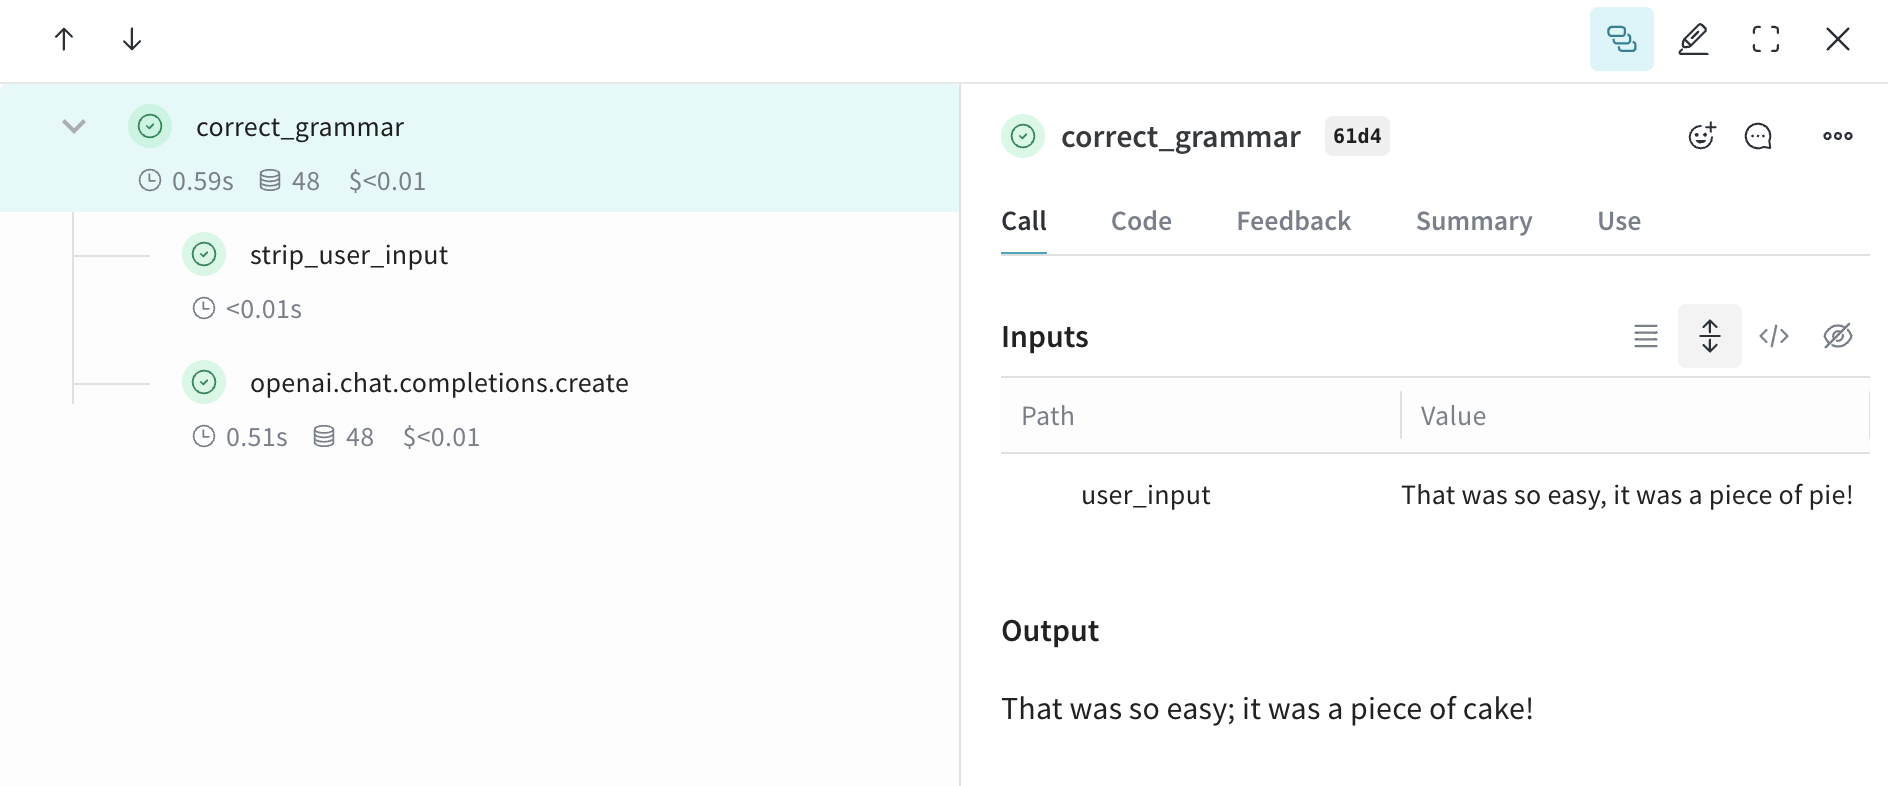

## Tracing Media objects
Weave supports logging and displaying multiple first class media types. Log images with PIL.Image.Image and audio with wave.Wave_read either directly with the object API, or as the inputs or output of an op. See below example for images, for audio check out our [in-depth cookbook](https://weave-docs.wandb.ai/reference/gen_notebooks/audio_with_weave)

In [ ]:
import weave
from openai import OpenAI
import requests
from PIL import Image

weave.init(f'{ENTITY}/{PROJECT}')
client = OpenAI()

@weave.op
def generate_image(prompt: str) -> Image:
    response = client.images.generate(
        model="dall-e-3",
        prompt=prompt,
        size="1024x1024",
        quality="standard",
        n=1,
    )
    image_url = response.data[0].url
    image_response = requests.get(image_url, stream=True)
    image = Image.open(image_response.raw)

    # return a PIL.Image.Image object to be logged as an image
    return image

generate_image("a cat with a pumpkin hat")

# Prompts


Creating, evaluating, and refining prompts is a core activity for AI engineers. Small changes to a prompt can have big impacts on your application's behavior. [Weave's Prompts](https://weave-docs.wandb.ai/guides/core-types/prompts) lets you create prompts, save and retrieve them, and evolve them over time.
When you publish one of these objects with `weave.publish()`, it will appear in your Weave project on the "Prompts" page.

## String Prompts:

In [ ]:
import weave, os, openai

weave.init(f'{ENTITY}/{PROJECT}')

# Create your prompt object with Weave
system_prompt = weave.StringPrompt("You are a grammar checker, correct the following user input.")
# Publish your prompt to weave
weave.publish(system_prompt, name="grammar-ckecker_prompt")

client = openai.OpenAI(
    base_url=os.getenv("OPENAI_BASE_URL", "https://api.inference.wandb.ai/v1"),
    api_key=os.getenv("WANDB_API_KEY"),
    project=f"{ENTITY}/{PROJECT}",
)
response = client.chat.completions.create(
  model="meta-llama/Llama-3.1-8B-Instruct",
  messages=[
    {
      "role": "system",
      "content": system_prompt.format() # <-- calling Llama with weave prompt
    },
    {
      "role": "user",
      "content":  "That was so easy, it was a piece of pie!"
    }
  ],
)

Perhaps this prompt does not yield the desired effect, so we modify the prompt to be more clearly instructive. Weave automatically versions the prompt for you.

In [ ]:
import weave, os, openai

weave.init(f'{ENTITY}/{PROJECT}')

# Editing the prompt
system_prompt = weave.StringPrompt("You are a grammar checker, correct the following user input. Explain your answer.")
# Publish the new edits
weave.publish(system_prompt, name="grammar-ckecker_prompt")

client = openai.OpenAI(
    base_url=os.getenv("OPENAI_BASE_URL", "https://api.inference.wandb.ai/v1"),
    api_key=os.getenv("WANDB_API_KEY"),
    project=f"{ENTITY}/{PROJECT}",
)
response = client.chat.completions.create(
  model="meta-llama/Llama-3.1-8B-Instruct",
  messages=[
    {
      "role": "system",
      "content": system_prompt.format()
    },
    {
      "role": "user",
      "content":  "That was so easy, it was a piece of pie!"
    }
  ],
)

On the Prompts page, you will be able to view and compare different verions of the prompts by 1) clicking on the prompt name object 2) click on the name of the prompt on the object page, in this example `grammar-ckecker_prompt
(3 versions) ` 3) selecting the versions you would like to compare and hitting "compare" button in the above right corner.

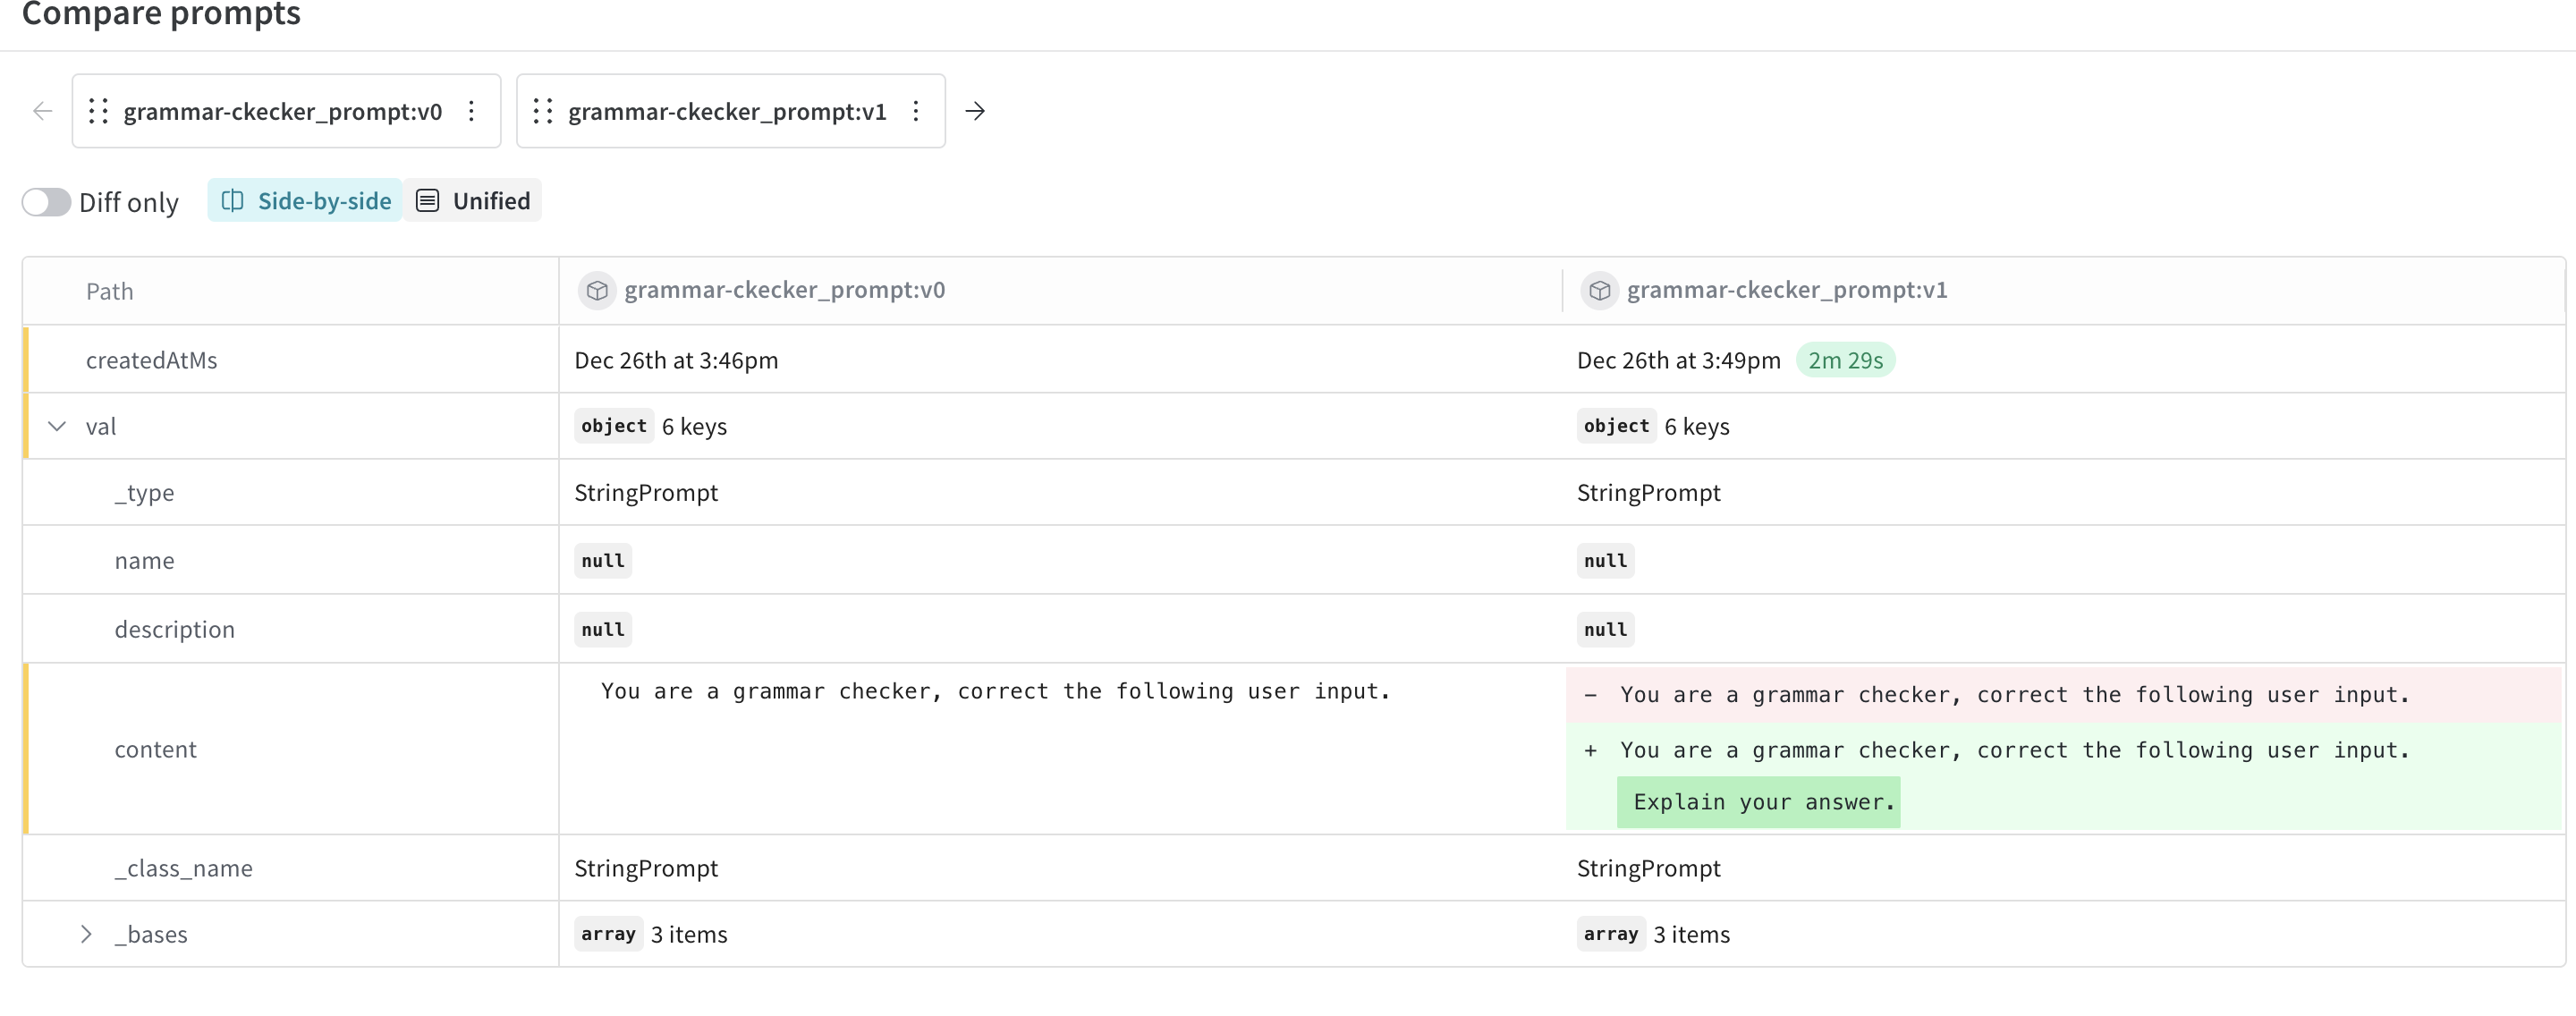

## Messages Prompt:

In addition to the StringPrompt, Weave provides MessagesPrompt. The `MessagesPrompt()` object can be used to replace an array of a Messages objects.


In [ ]:
import weave

weave.init(f'{ENTITY}/{PROJECT}')

prompt = weave.MessagesPrompt([
    {
        "role": "system",
        "content": "You are a grammar checker, correct the following user input. Explain your answer."
    },
    {
        "role": "user",
        "content":  "That was so easy, it was a piece of pie!"
    }
])
weave.publish(prompt, name="grammar-ckecker_prompt")

response = client.chat.completions.create(
  model="meta-llama/Llama-3.1-8B-Instruct",
  messages=prompt.format(),
)

# Evaluations

To systematically improve your application, it's helpful to test your changes against a consistent dataset of potential inputs so that you catch regressions and can inspect your apps behaviour under different conditions. Using the [Evaluation](https://weave-docs.wandb.ai/reference/python-sdk/weave/#class-evaluation) class, you can be sure you're comparing apples-to-apples by keeping track of all of the details that you're experimenting and evaluating with.

## 1. Define an evaluation dataset

`Datasets()` enable you to collect examples for evaluation and automatically track versions for accurate comparisons.  These examples are often failure cases that you want to test for, these are similar to unit tests in Test-Driven Development (TDD).

In [ ]:
import weave

weave.init(f'{ENTITY}/{PROJECT}')

# Create a dataset
dataset = weave.Dataset(
    name='grammar-eval-dataset',
    rows=[
        {'id': '0', 'sentence': "He no likes ice cream.", 'correction': "He doesn't like ice cream."},
        {'id': '1', 'sentence': "She goed to the store.", 'correction': "She went to the store."},
        {'id': '2', 'sentence': "They plays video games all day.", 'correction': "They play video games all day."}
    ]
)

# Publish the dataset
weave.publish(dataset)

# Retrieve the dataset
dataset_ref = weave.ref('grammar-eval-dataset').get()

# Access a specific example
example_label = dataset_ref.rows[2]['sentence']
print(example_label)

## 2. Defining scoring functions

In Weave, [Scorers](https://weave-docs.wandb.ai/guides/evaluation/scorers) are used to evaluate LLM's outputs and return evaluation metrics. They take the LLM's output, analyze it, and return a dictionary of results. You can build your own scorers or use the predefined scorers provided by Weave.

Let's begin by creating a simple scorer. This scorer will compare the LLM's output to the dataset we previously established. Just make sure to add `@weave.op()` to track this function's calls

In [ ]:
@weave.op()
def match_score1(correction: str, sentence: str, output: dict) -> dict:
    # Here is where you'd define the logic to score the model output
    return {'match': correction == output['generated_text']}

To use Weave's [predefined scorers](https://weave-docs.wandb.ai/guides/evaluation/scorers#predefined-scorers) we'll need to install some additional dependencies:


In [ ]:
%%capture
!pip install weave[scorers]

In this example, we'll utilize one of the Weave's LLM-as-Judge scorers, `HallucinationFreeScorer` to assess the presence of hallucinations in the AI's output. This scorer uses a specified model (e.g., 'gpt-4o') as the judge to determine if the output contains hallucinations based on the provided input data. The scorer expects an input column named `context`. If your dataset uses a different name, use the `column_map` attribute to map context to the dataset column. In this case, we used `sentence` in the `grammar-eval-dataset`





In [ ]:
from weave.scorers import HallucinationFreeScorer

# we need to pass the LLM client and the model to be used as 'LLM-as-judge'
hallucination_scorer = HallucinationFreeScorer(
    model_id="openai/meta-llama/Llama-3.1-8B-Instruct",
    column_map={"context": "sentence"}
)

## 3. Run an Evaluation

Finally, let's run an evaluation with the dataset and the scorers we created so far.  We'll utilize  the `weave.Evaluation` object for this purpose. This object takes the dataset, applies the function/model to each row's 'sentence' column, and then passes the results along with the original sentence to the scorers for evaluation.

In [ ]:
import asyncio
import weave, os, openai

# getting our saved prompt from earlier 🤓
system_prompt = weave.ref("grammar-ckecker_prompt:v0").get()

@weave.op()
def model_to_evaluate(sentence: str):
    # here's where you would add your LLM call and return the output
    client = openai.OpenAI(
        base_url=os.getenv("OPENAI_BASE_URL", "https://api.inference.wandb.ai/v1"),
        api_key=os.getenv("WANDB_API_KEY"),
        project=f"{ENTITY}/{PROJECT}",
    )
    response = client.chat.completions.create(
    model="meta-llama/Llama-3.1-8B-Instruct",
    messages=[
      {
        "role": "system",
        "content": system_prompt.format()
      },
      {
        "role": "user",
        "content": sentence
      }
      ],
    )
    return  {'generated_text': response.choices[0].message.content}

evaluation = weave.Evaluation(
    dataset=dataset_ref, scorers=[match_score1, hallucination_scorer], name="My Evaluation"
)

print(await (evaluation.evaluate(model_to_evaluate)) )

Another option to run evaluation is to use the `EvaluationLogger` which provides a flexible, incremental way to log evaluation data directly from your Python code.

In [ ]:
from weave import EvaluationLogger

weave.init(f"{ENTITY}/{PROJECT}")

# Initialize EvaluationLogger BEFORE calling the agent to ensure token tracking
eval_logger = EvaluationLogger(
    model="my_model",
    dataset="eval-dataset"
)

# Iterate through examples, predict, and log
for sample in dataset_ref:
    inputs = sample["sentence"]

    # call the model to evaluate
    model_output = model_to_evaluate(inputs) # Pass inputs as kwargs
    # Log the prediction input and output
    pred_logger = eval_logger.log_prediction(
        inputs=sample,
        output=model_output
    )

    # Calculate and log a score for this prediction
    match_s = match_score1(sample["correction"], sample["sentence"], model_output)

    pred_logger.log_score(
        scorer="match_score", # Simple string name for the scorer
        score= match_s
    )

    # Finish logging for this specific prediction
    pred_logger.finish()

# Log a final summary for the entire evaluation.
# Weave auto-aggregates the scores logged above.
summary_stats = {"subjective_overall_score": 0.8}
eval_logger.log_summary(summary_stats)

print("Evaluation logging complete. View results in the Weave UI.")

# Online Evaluations (aka Monitors & Guardrails)

How to score a trace outside of an evaluation. AKA how to implement a monitor or a guardrail. In Weave you can use the same scoring class as a monitor or a guardrail. First, let's the use the built-in hallucination scorer for this example:

## Basic Scorer Example

In [ ]:
import weave
from weave import Scorer

weave.init(f'{ENTITY}/{PROJECT}')

class LengthScorer(Scorer):
    @weave.op
    def score(self, output: str) -> dict:
        """A simple scorer that checks output length."""
        return {
            "length": len(output),
            "is_short": len(output) < 100
        }

## Using Scorers as Guardrails

In [ ]:
import weave
from weave import Scorer

weave.init(f'{ENTITY}/{PROJECT}')

@weave.op
def generate_text(prompt: str) -> str:
    """Generate text using an LLM."""
    # Your LLM generation logic here
    return "Generated response..."

class ToxicityScorer(Scorer):
    @weave.op
    def score(self, output: str) -> dict:
        """
        Evaluate content for toxic language.
        """
        # Your toxicity detection logic here
        return {
            "flagged": False,  # True if content is toxic
            "reason": None     # Optional explanation if flagged
        }

async def generate_safe_response(prompt: str) -> str:
    # Get result and Call object
    result, call = generate_text.call(prompt)
    
    # Check safety
    safety = await call.apply_scorer(ToxicityScorer())
    if safety.result["flagged"]:
        return f"I cannot generate that content: {safety.result['reason']}"
    
    return result

await generate_safe_response("Write a tweet about AI safety.")


## Using Scorers as Monitors

In [ ]:
@weave.op
def generate_text(prompt: str) -> str:
    return "Hello, world!"

# Get both result and Call object
result, call = generate_text.call("Say hello")

# Now you can apply scorers
await call.apply_scorer(LengthScorer())

# Define a Model to evaluate (optional)

A Weave `Model` is a combination of data (which can include configuration, trained model weights, or other information) and code that defines how the model operates. By structuring your code to be compatible with this API, you benefit from a structured way to version your application so you can more systematically keep track of your experiments.

To create a model in Weave, you need the following:



1. A class that inherits from `weave.Model`
2. Type definitions on all attributes
3. A typed predict function with `@weave.op()` decorator


Let's do this with our `model_to_evaluate()`




In [ ]:
import weave, os, openai

weave.init(f'{ENTITY}/{PROJECT}')

class grammar_checker_model(weave.Model):
    system_prompt: weave.StringPrompt
    model_name: str

    @weave.op()
    def predict(self, sentence: str) -> dict:
        # Model logic goes here
        client = openai.OpenAI(
            base_url=os.getenv("OPENAI_BASE_URL", "https://api.inference.wandb.ai/v1"),
            api_key=os.getenv("WANDB_API_KEY"),
            project=f"{ENTITY}/{PROJECT}",
        )
        response = client.chat.completions.create(
        model=self.model_name,
        messages=[
          {
            "role": "system",
            "content": system_prompt.format()
          },
          {
            "role": "user",
            "content": sentence
          }
          ],
        )
        return  {'generated_text': response.choices[0].message.content}

system_prompt = weave.ref("grammar-ckecker_prompt:v0").get()

# model = grammar_checker_model(system_prompt=system_prompt, model_name="meta-llama/Llama-3.1-70B-Instruct")
model = grammar_checker_model(system_prompt=system_prompt, model_name="meta-llama/Llama-3.1-8B-Instruct")

evaluation = weave.Evaluation(
    dataset=dataset_ref, scorers=[match_score1, hallucination_scorer], name="My Evaluation"
)
await evaluation.evaluate(model)

Weave's UI now allows for comparison of structured evaluations. To compare evaluations, navigate to the 'Evals' tab in the left sidebar. Select the desired evaluations and click the 'Compare' button located in the top right corner:

 In this instance, a comparison of claude-3-5-sonnet and gpt-4o reveals that gpt-4o performed better for both od our scoring metrics.

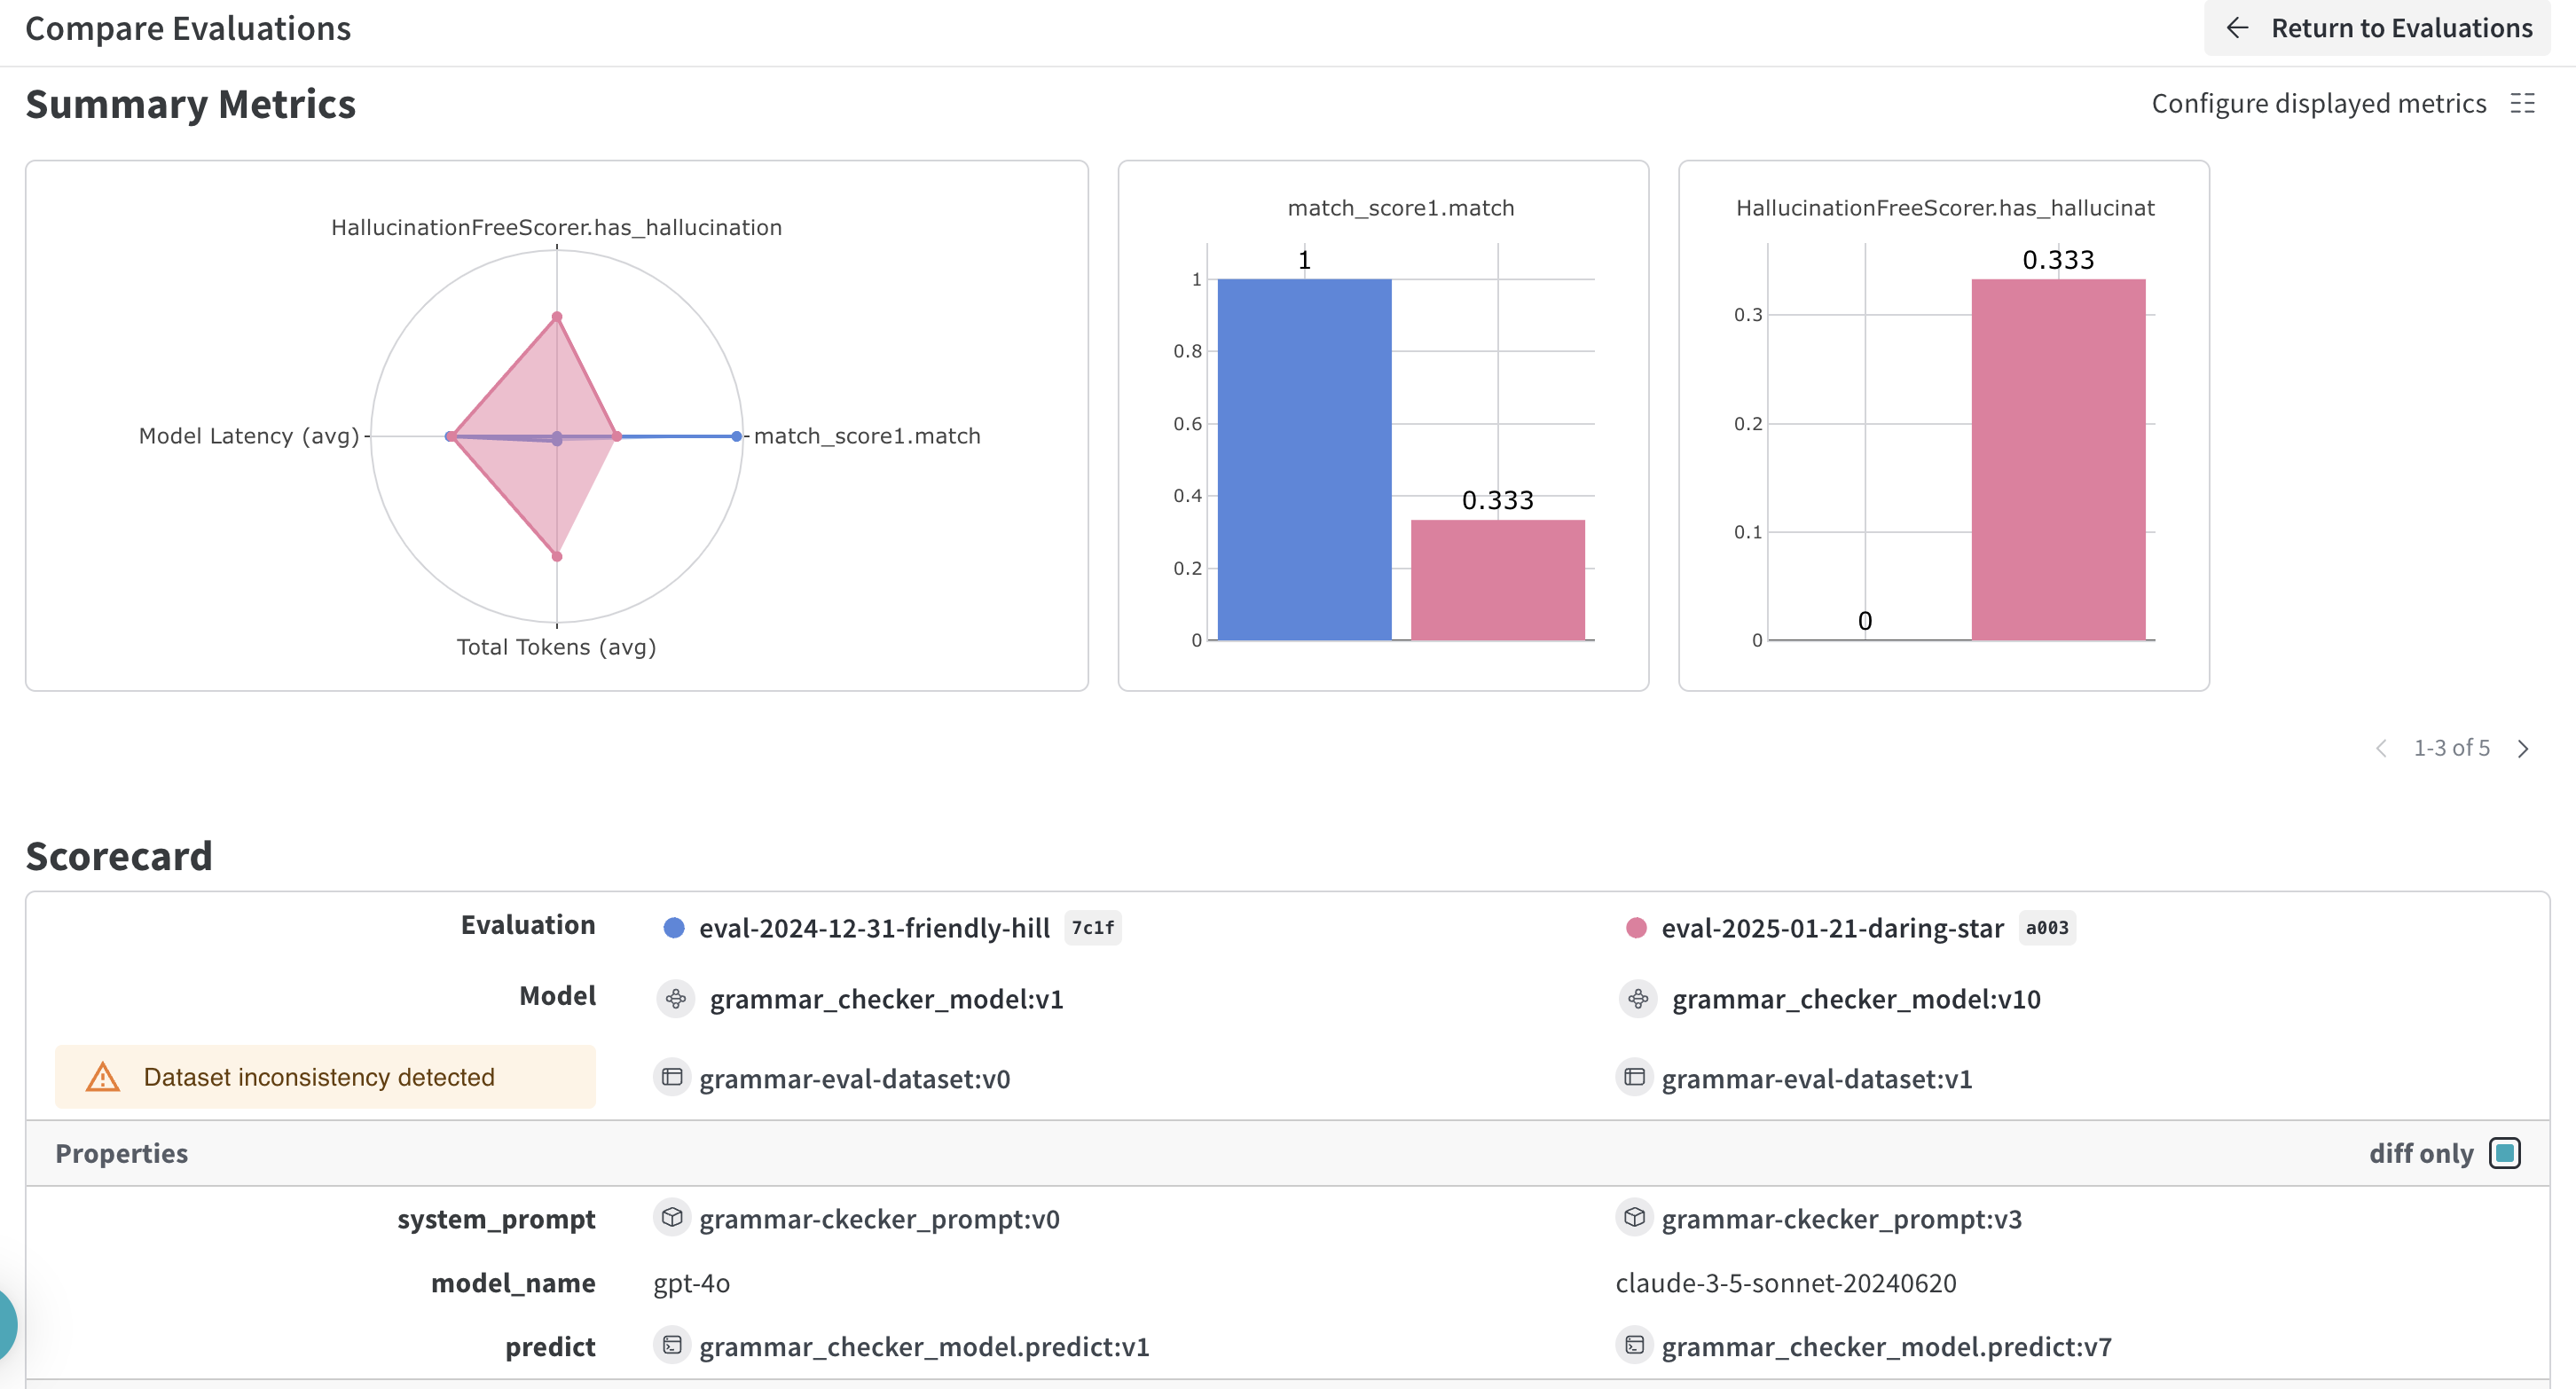

Let's utilize Weave's analysis tools to understand Claude's underperformance. By filtering the results based on relevant metrics, such as the hallucination scorer, we can identify specific instances where Claude deviates significantly from the expected outcome, for example, where Claude scores 0 and GPT-4 scores 100. Upon closer inspection, we discover that Claude replaced "They" with "He", which was flagged by the hallucination scorer.

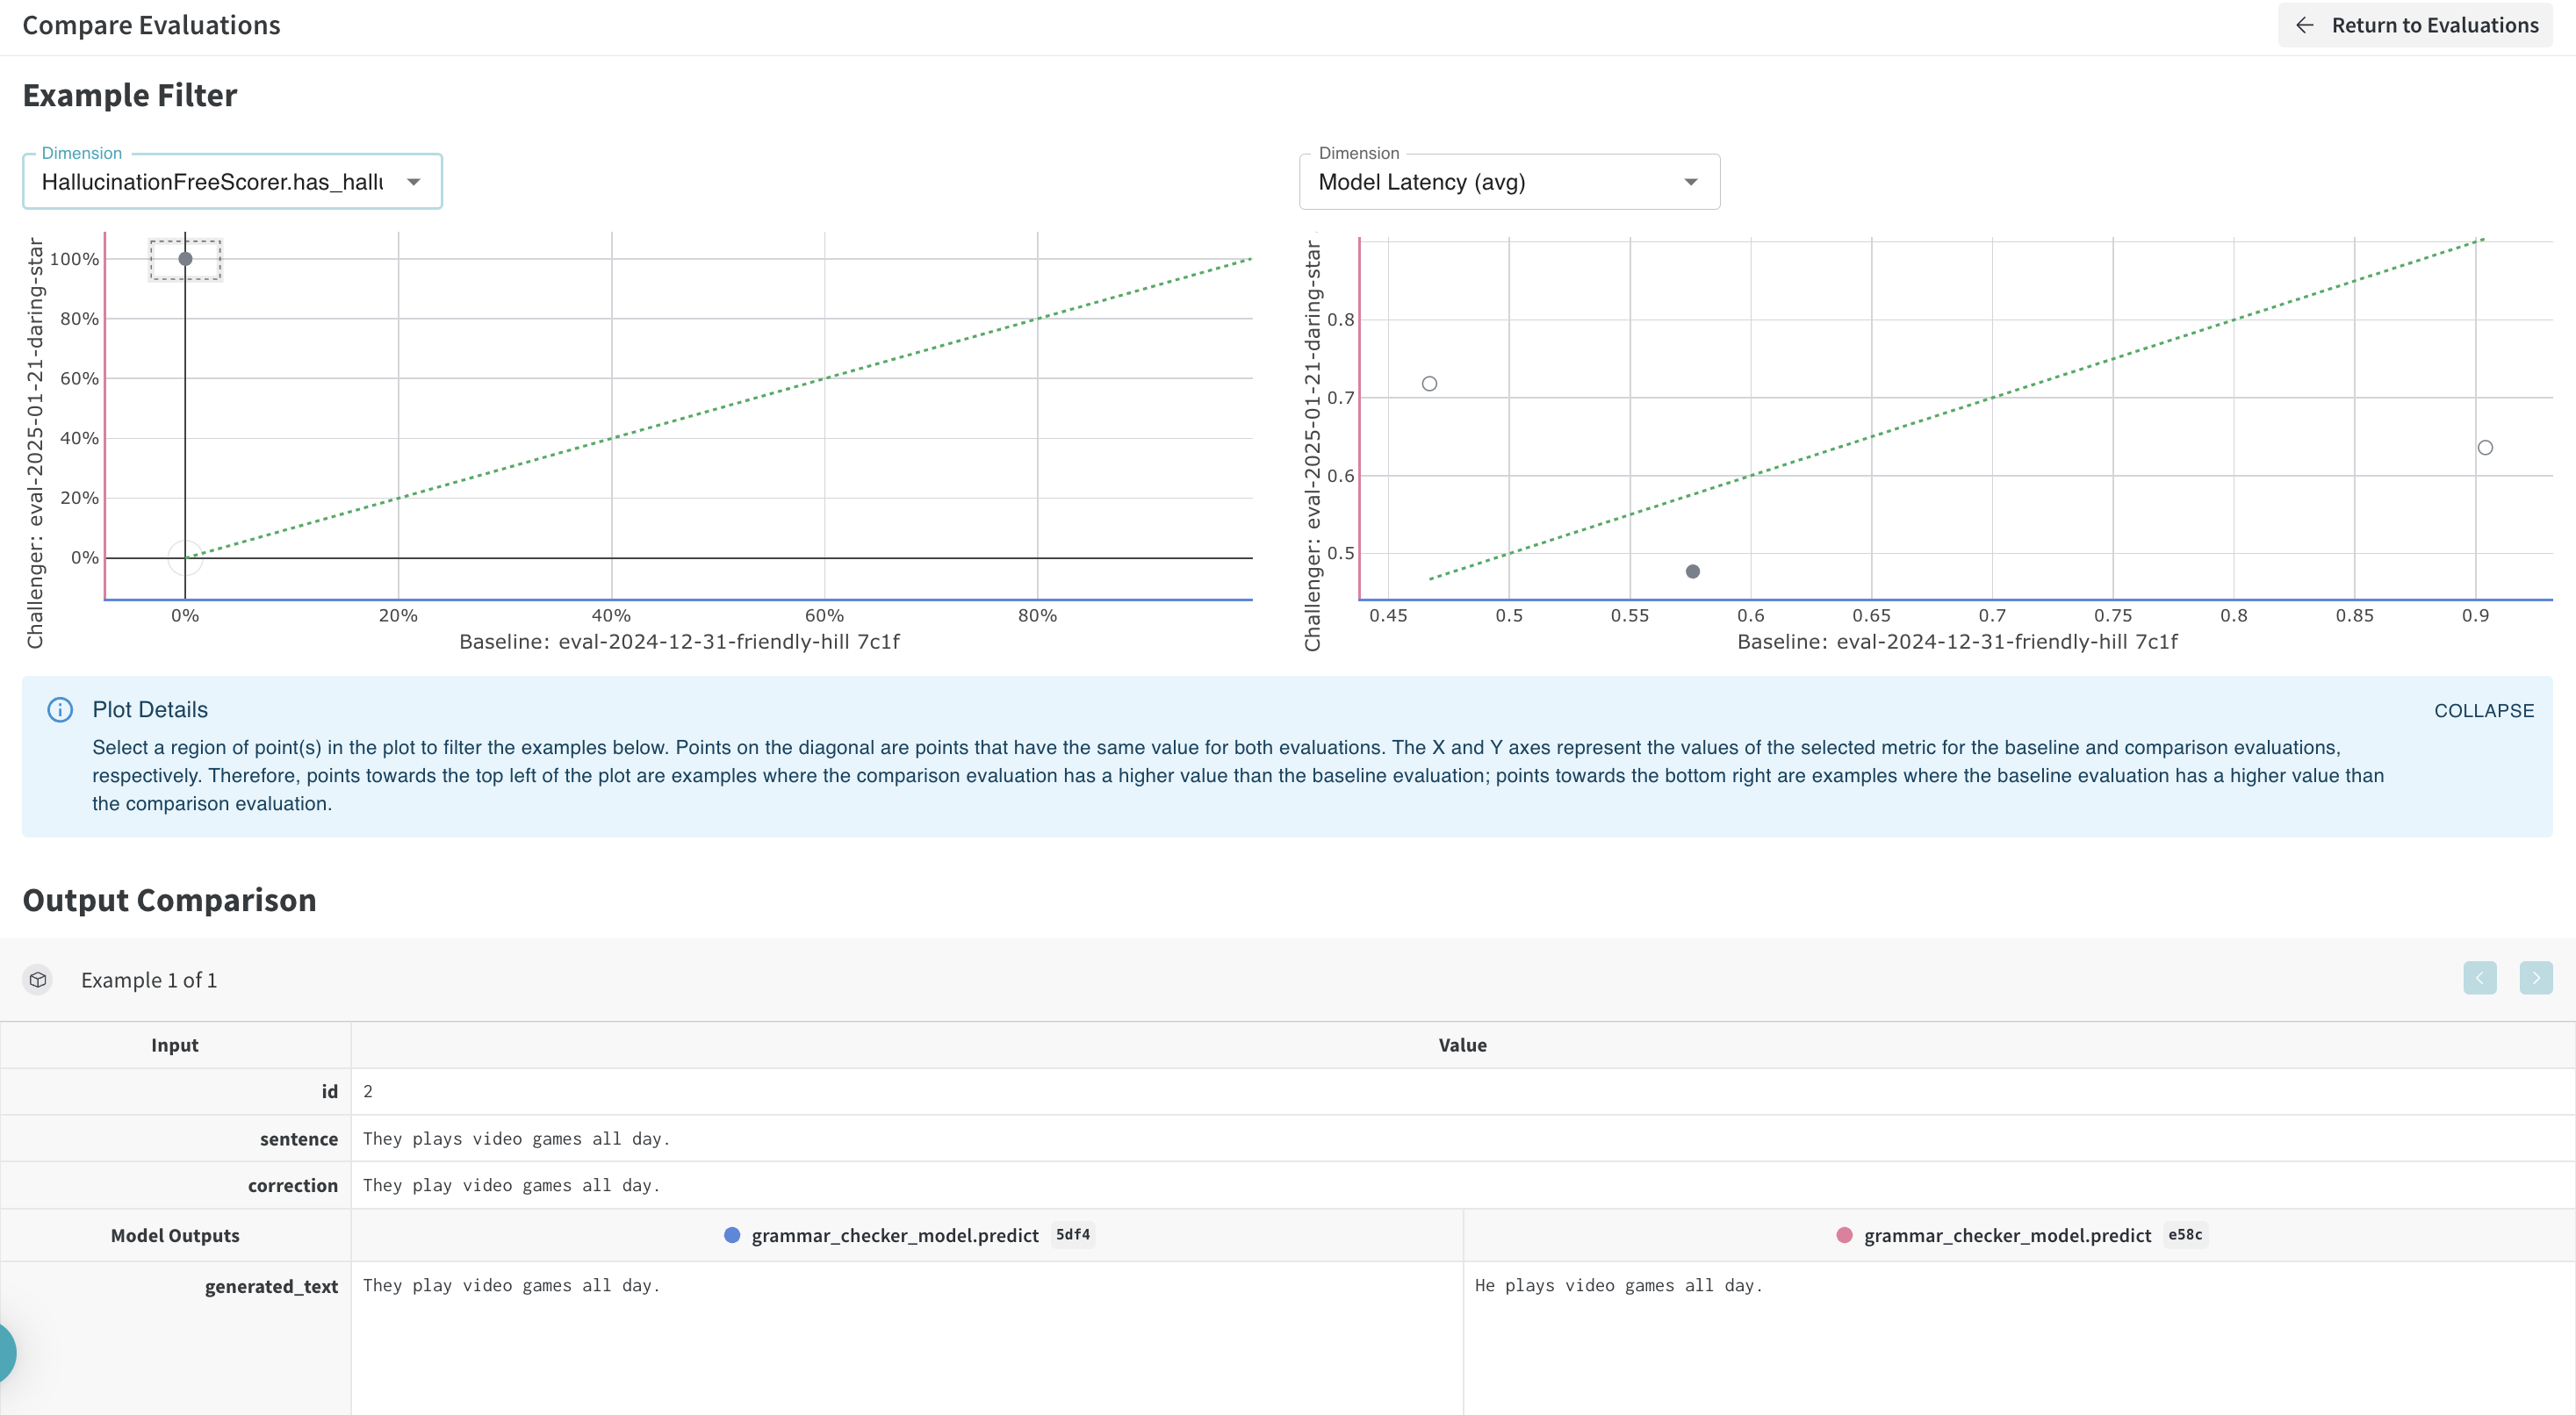

# Weave Agentic Clinical Document Writer

This Colab is a guided clinical-authoring demo that turns free-text patient notes into polished, structured SOAP-style documentation. Under the hood it leverages LangGraph, a graph-based orchestration layer, together with Weave, which provides a workspace for building, running, and monitoring each step of your authoring pipeline.

Weave not only makes it easy to wire together prompts, tools, and LLM calls, but its built-in instrumentation automatically tracks each node's inputs, outputs, timings, and state changes—so you can visualize exactly how your outline, draft, critique, and revision steps execute and pinpoint any bottlenecks or errors in real time.

In [ ]:
from typing import Any, List, Dict, Optional, TypedDict
import weave
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI  # Uses OPENAI_API_KEY and OPENAI_API_BASE env vars

In [ ]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    initial_draft: str 
    critique: str
    revision_number: int
    max_revisions: int

Loading our prompts

In [ ]:
PLAN_PROMPT = """You are an expert clinical author.  You will take the user’s unstructured clinical notes (free-text) and:
1. Propose a richly detailed outline using the SOAP format (Subjective, Objective, Assessment, Plan).
2. For each section, list at least 5 key data points you’ll extract (e.g., chief complaint, past history details, vitals, physical exam findings, working diagnosis, proposed interventions), with brief explanatory notes.
3. Ensure the outline demonstrates clinical depth appropriate for a peer-reviewed case report.
"""

WRITER_PROMPT = """You are a clinical writing assistant.  Given the author’s unstructured notes and the SOAP outline you just generated:
- Produce a fully fleshed-out SOAP note of approximately 1,500–1,800 words.
- Each section (S, O, A, P) should be at least 300 words, with complete sentences, relevant clinical detail, and citations to guidelines or literature where appropriate.
- Preserve all numeric data verbatim; infer only when clinically reasonable.
Return only the final SOAP note."""

REFLECTION_PROMPT = """You are a senior clinician performing a strict, actionable review of a SOAP note DRAFT.
Return feedback in this exact structure and keep it concise and prescriptive:

[ISSUES]
- {Section}: Issue → Why it’s a problem (cite specific guideline/section or standard where possible)

[REVISION PLAN]
- {Section} | Action: [ADD|REWRITE|REMOVE|CITE|VERIFY]
  Change: exact text to add/replace, or precise instruction
  Acceptance Criteria: how we’ll know it’s fixed (e.g., “includes full vitals w/ units & normal ranges”, “adds NPIAP 2019 citation for NPWT”)

[BLOCK-LEVEL SUGGESTIONS]
- Provide 1–3 sentence rewrites for any unclear paragraphs.

Rules:
- Point directly to sections (Subjective, Objective, Assessment, Plan).
- Preserve all numeric values verbatim unless you flag VERIFY.
- Prefer short, targeted edits over general advice.
"""

REWRITER_SYSTEM_PROMPT = """You are an expert medical editor.
Your job is to REWRITE the previous draft by APPLYING EVERY ACTIONABLE ITEM in CRITIQUE.
Rules:
- Treat each critique item as a mandatory change request.
- If two critique items conflict, prefer the stricter requirement.
- Do not keep sentences verbatim unless the critique says to preserve them. Rewrite in your own words while keeping clinical facts.
- Preserve ALL numeric values, units, and patient identifiers unless CRITIQUE says VERIFY/CHANGE.
- Keep SOAP section headings and order.
- Output ONLY the final SOAP note (no commentary)."""


In [ ]:
def build_graph(llm_model: Any):
    """
    Build the LangGraph used by DocumentWriter. Mirrors the notebook,
    but parameterized on the provided llm_model.
    """
    memory = MemorySaver()

    @weave.op()
    def plan_node(state: AgentState, llm_model=llm_model):
        messages = [SystemMessage(content=PLAN_PROMPT), HumanMessage(content=state["task"])]
        response = llm_model.invoke(messages)
        return {"plan": response.content}

    @weave.op()
    def generation_node(state: AgentState, llm_model=llm_model):
        """
        Initial: write from task + plan.
        Revision: strictly APPLY critique to the prior draft; forbid bullets; retry if too similar.
        """
        has_critique = bool(str(state.get("critique", "")).strip())
        has_draft = bool(str(state.get("draft", "")).strip())
        rev_num = int(state.get("revision_number", 1))

        if has_critique and has_draft:
            # REVISION PATH (entire block stays INSIDE this if)
            prompt = f"""
    You are a clinical writing assistant revising a SOAP note.

    CONTEXT
    Task:
    {state['task']}

    OUTLINE (for consistency only; do not re-outline):
    {state['plan']}

    PREVIOUS DRAFT (DRAFT_{max(1, rev_num-1)}):
    <<<DRAFT>>>
    {state['draft']}
    <<<END DRAFT>>>

    CRITIQUE (mandatory change requests; apply each one):
    <<<CRITIQUE>>>
    {state['critique']}
    <<<END CRITIQUE>>>

    INSTRUCTIONS
    - Produce DRAFT_{rev_num} by applying EVERY actionable item from CRITIQUE.
    - Rewrite sentences; do not keep phrasing identical to the previous draft.
    - Keep SOAP section headings; write paragraphs only (NO bullet lists).
    - Preserve numeric values verbatim unless CRITIQUE says VERIFY/CHANGE.
    - Return ONLY the full revised SOAP note (no commentary).
    """
            messages = [
                SystemMessage(content=REWRITER_SYSTEM_PROMPT),
                HumanMessage(content=prompt),
            ]

            def _invoke(msgs):
                resp = llm_model.invoke(msgs)
                content = getattr(resp, "content", "")
                if isinstance(content, str):
                    return content
                return "".join((p.get("text", "") if isinstance(p, dict) else str(p)) for p in (content or []))

            new_text = _invoke(messages) or ""

            # If too similar to prior draft, force a stronger rewrite
            try:
                import difflib
                prev = state.get("draft", "") or ""
                similarity = difflib.SequenceMatcher(None, prev, new_text).ratio()
            except Exception:
                prev = state.get("draft", "") or ""
                similarity = 1.0 if new_text.strip() == prev.strip() else 0.0

            if similarity > 0.98:
                retry = prompt + "\n\nYour last revision was too similar. Rewrite more assertively (no bullets), apply EVERY critique item, and vary the phrasing."
                new_text = _invoke([SystemMessage(content=REWRITER_SYSTEM_PROMPT), HumanMessage(content=retry)]) or new_text

            if not new_text.strip():
                new_text = state.get("draft", "") or ""

            return {
                "draft": new_text,
                "revision_number": rev_num + 1,
            }

        # INITIAL DRAFT PATH (MUST be inside the function, under the else case)
        prompt = (
            f"{WRITER_PROMPT}\n\n"
            f"Task:\n{state['task']}\n\n"
            f"SOAP Outline:\n{state['plan']}\n\n"
            "Return only the full SOAP note (no bullets)."
        )
        messages = [HumanMessage(content=prompt)]
        draft_text = ""
        try:
            response = llm_model.invoke(messages)
            content = getattr(response, "content", "")
            if isinstance(content, str):
                draft_text = content
            else:
                draft_text = "".join(
                    (part.get("text", "") if isinstance(part, dict) else str(part))
                    for part in (content or [])
                )
        except Exception:
            draft_text = ""

        if not draft_text.strip():
            draft_text = (
                f"Subjective:\n{state['task']}\n\n"
                f"Objective:\nGenerated per outline.\n\n"
                f"Assessment:\nDraft based on plan.\n\n"
                f"Plan:\n{state['plan']}\n"
            )

        return {
            "draft": draft_text,
            "initial_draft": state.get("initial_draft", draft_text),  # capture first draft once
            "revision_number": rev_num + 1,
        }

    @weave.op()
    def critique_node(state: AgentState, llm_model=llm_model):
        # Critique the FIRST draft; force specificity and quotes
        target = state.get("initial_draft") or state.get("draft", "") or ""
        messages = [
            SystemMessage(content=REFLECTION_PROMPT),
            HumanMessage(content=(
                "Review the INITIAL DRAFT and produce [ISSUES], [REVISION PLAN], [BLOCK-LEVEL SUGGESTIONS]. "
                "For EVERY issue and planned change include a line starting with 'Quote:' that copies a short exact snippet "
                "from the INITIAL DRAFT that the point refers to. "
                "Only include points directly supported by the INITIAL DRAFT; omit generic advice. "
                "No bullet list substitutions; focus on sentence-level rewrites and missing clinical facts.\n\n"
                f"{target}"
            )),
        ]
        critique_text = ""
        try:
            response = llm_model.invoke(messages)
            content = getattr(response, "content", "")
            if isinstance(content, str):
                critique_text = content
            else:
                critique_text = "".join(
                    (part.get('text', '') if isinstance(part, dict) else str(part))
                    for part in (content or [])
                )
        except Exception:
            critique_text = ""

        if not critique_text.strip():
            critique_text = (
                "Critique:\n"
                "- Identify at least 5 concrete, draft-anchored issues across S/O/A/P.\n"
                "- For each: add 'Quote:' with the exact line, a one-line fix, and acceptance criteria.\n"
            )
        return {"critique": critique_text}
        
    @weave.op()
    def should_continue(state: AgentState):
        if state["revision_number"] > state["max_revisions"]:
            return END
        return "critique"

    builder = StateGraph(AgentState)
    builder.add_node("planner", plan_node)
    builder.add_node("generate", generation_node)
    builder.add_node("critique", critique_node)
    builder.set_entry_point("planner")
    builder.add_conditional_edges("generate", should_continue, {END: END, "critique": "critique"})
    builder.add_edge("planner", "generate")
    builder.add_edge("critique", "generate")
    graph = builder.compile(checkpointer=memory)
    return graph

In [ ]:
class DocumentWriter(weave.Model):
    """Weave Model wrapper for the LangGraph clinical author"""
    graph: Any
    llm_model: Any
    session: Optional[Any]
    max_revisions: int = 2

    def __init__(self, graph: Any, llm_model: Any, session: Optional[Any] = None, max_revisions: int = 2):
        super().__init__(graph=graph, llm_model=llm_model, session=session, max_revisions=max_revisions)

    @weave.op()
    def predict(self, input: str):
        thread = {"configurable": {"thread_id": "1"}}
        final_state = None
        for s in self.graph.stream(
            {
                "task": f"{input}",
                "max_revisions": self.max_revisions,
                "revision_number": 1,
                "plan": "",
                "draft": "",
                "critique": ""
            },
            thread,
        ):
            final_state = s
        return final_state["generate"]["draft"]

Building the graph with the openai model

In [ ]:
llm_model = ChatOpenAI(model="meta-llama/Llama-3.1-8B-Instruct", max_tokens=4096)
graph = build_graph(llm_model=llm_model)

In [ ]:
weave.init(f"{ENTITY}/{PROJECT}")
model = DocumentWriter(graph=graph, llm_model=llm_model)

Run a prediction and follow the outputted link to see the full trace!

Note: this will take awhile to run

In [ ]:
# running a prediction with some unstructured patient notes
model.predict("""Patient presented calm and cooperative today, though appeared somewhat fatigued.
Reports sleeping inconsistently over the past week, averaging about five hours per night.
Appetite remains fair; denies major changes in weight.
Mentions ongoing mild anxiety about work deadlines but says coping strategies like walking and journaling have helped somewhat.
No acute mood swings or panic episodes noted. Affect is appropriate, thought process logical and goal-directed.
Denies suicidal or homicidal ideation. Energy level described as “okay but not great.” Continues taking prescribed medication as directed, no reported side effects.
Expresses interest in exploring adjustments to routine to improve sleep consistency and reduce daytime fatigue.
Will monitor over the next couple of weeks before considering medication changes.""")